# Brain Tumour Segmentation Network
## Import packages
Please make sure you have all the required packages installed for this project.

In [21]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import vgg16
import torch.nn.functional as F
from PIL import Image
import nibabel as nib
from pathlib import Path
from typing import List, Optional
import torchio as tio
import zipfile
from scipy.ndimage import zoom

In [2]:
# Set device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Using device: cuda


In [3]:
base_dirs = ['Train', 'Val']
for d in base_dirs:
    if os.path.exists(d):
        shutil.rmtree(d)
    os.makedirs(d, exist_ok=True)

# Split dataset into training and validation sets
dataset_path = 'dataset_segmentation/train/'
train_list = []
val_list = []

# 获取所有病例文件夹
all_cases = [d for d in os.listdir(dataset_path) if not d.startswith('.') and os.path.isdir(os.path.join(dataset_path, d))]
random.shuffle(all_cases)

# 计算分割点
num_cases = len(all_cases)
split_idx = int(0.8 * num_cases)  # 80% for training

# 分割数据集
for i, case_name in enumerate(all_cases):
    case_dir = os.path.join(dataset_path, case_name)
    
    if i < split_idx:
        # 训练集 - 创建对应的病例文件夹
        dest_case_dir = os.path.join('Train', case_name)
        shutil.copytree(case_dir, dest_case_dir)
        train_list.append(case_name)
    else:
        # 验证集 - 创建对应的病例文件夹
        dest_case_dir = os.path.join('Val', case_name)
        shutil.copytree(case_dir, dest_case_dir)
        val_list.append(case_name)

print(f'Training samples: {len(train_list)}')
print(f'Validation samples: {len(val_list)}')

Training samples: 168
Validation samples: 42


## Visualise MRI Volume Slices and Segmentation Maps
Each MRI image contains information about a three-dimensional (3D) volume of space. An MRI image is composed of a number of voxels, which are like pixels in 2D images. Here, try to visualise the axial plane (which usually has higher resolution) of some of the volumes and the corresponding segmentation maps.

In [4]:
def show_axial_slices(
    mri_path: str,
    mask_path: str,
    case_id: str,
    num_slices: int = 5,
    save_path: Optional[str] = None
):
    """
    Visualize axial slices of MRI volumes and corresponding segmentation maps
    
    Args:
        mri_path (str): Path to the MRI volume file (.nii.gz)
        mask_path (str): Path to the segmentation mask file (.nii.gz)
        case_id (str): Case identifier for labeling
        num_slices (int): Number of axial slices to display
        save_path (str, optional): If provided, save figure to this path
    """
    if not os.path.exists(mri_path):
        raise FileNotFoundError(f"MRI file not found: {mri_path}")
    if not os.path.exists(mask_path):
        raise FileNotFoundError(f"Mask file not found: {mask_path}")

    mri = nib.load(mri_path).get_fdata()
    mask = nib.load(mask_path).get_fdata()

    if mri.shape != mask.shape:
        raise ValueError(f"Shape mismatch: MRI {mri.shape} vs Mask {mask.shape}")

    print(f"Case {case_id} volume dimensions: {mri.shape}")

    # Select evenly spaced slices (avoid first and last)
    slice_indices = np.linspace(0, mri.shape[2] - 1, num_slices + 2, dtype=int)[1:-1]

    fig, axes = plt.subplots(num_slices, 2, figsize=(12, 3 * num_slices))
    fig.suptitle(f'Case {case_id} - Axial Plane Visualization', fontsize=16)

    if num_slices == 1:
        axes = np.array([[axes[0], axes[1]]])

    for i, slice_idx in enumerate(slice_indices):
        mri_slice = mri[:, :, slice_idx]
        mask_slice = mask[:, :, slice_idx]

        # Display MRI
        axes[i, 0].imshow(mri_slice.T, cmap='gray', origin='lower')
        axes[i, 0].set_title(f'MRI Axial Slice {slice_idx}')
        axes[i, 0].axis('off')

        # Display MRI + Overlay
        axes[i, 1].imshow(mri_slice.T, cmap='gray', origin='lower')

        # Create overlay (red for mask)
        overlay = np.zeros((*mask_slice.shape, 4))
        overlay[..., 0] = 1.0  # Red
        overlay[..., 3] = (mask_slice > 0).T * 0.5  # Alpha

        axes[i, 1].imshow(overlay, origin='lower')
        axes[i, 1].set_title(f'MRI with Segmentation (Slice {slice_idx})')
        axes[i, 1].axis('off')

        # Add tumor percentage
        tumor_percentage = (np.sum(mask_slice > 0) / np.prod(mask_slice.shape)) * 100
        axes[i, 1].text(0.05, 0.95, f'Tumor: {tumor_percentage:.2f}%',
                        transform=axes[i, 1].transAxes,
                        color='white', fontsize=10,
                        bbox=dict(facecolor='black', alpha=0.5))

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved visualization to {save_path}")
    plt.show()

In [5]:
def visualize_dataset(
    dataset_paths: List[str] = ['Train', 'Val'],
    num_cases: int = 2,
    num_slices: int = 3,
    save_dir: Optional[str] = None
):
    """
    Visualize axial slices for multiple cases in the dataset

    Args:
        dataset_paths (list): List of dataset paths to visualize
        num_cases (int): Number of cases to visualize from each dataset
        num_slices (int): Number of axial slices per case
        save_dir (str, optional): Directory to save visualizations
    """
    print("=== Starting Medical Image Visualization ===")
    print("Focus: Axial plane (typically highest resolution in MRI)")

    for dataset_path in dataset_paths:
        if os.path.exists(dataset_path):
            print(f"\n--- Visualizing {dataset_path} Dataset ---")

            case_folders = [f for f in os.listdir(dataset_path)
                            if os.path.isdir(os.path.join(dataset_path, f))][:num_cases]

            for case_folder in case_folders:
                case_path = os.path.join(dataset_path, case_folder)

                mri_file = None
                mask_file = None

                for file_name in os.listdir(case_path):
                    if 'fla' in file_name and file_name.endswith('.nii.gz'):
                        mri_file = os.path.join(case_path, file_name)
                    elif 'seg' in file_name and file_name.endswith('.nii.gz'):
                        mask_file = os.path.join(case_path, file_name)

                if mri_file and mask_file:
                    print(f"\nVisualizing case: {case_folder}")
                    save_path = None
                    if save_dir:
                        os.makedirs(save_dir, exist_ok=True)
                        save_path = os.path.join(save_dir, f"{dataset_path}_{case_folder}.png")
                    show_axial_slices(mri_file, mask_file, case_folder, num_slices, save_path)
                else:
                    print(f"Case {case_folder} is missing required files")

=== Starting Medical Image Visualization ===
Focus: Axial plane (typically highest resolution in MRI)

--- Visualizing Train Dataset ---

Visualizing case: 187
Case 187 volume dimensions: (240, 240, 155)


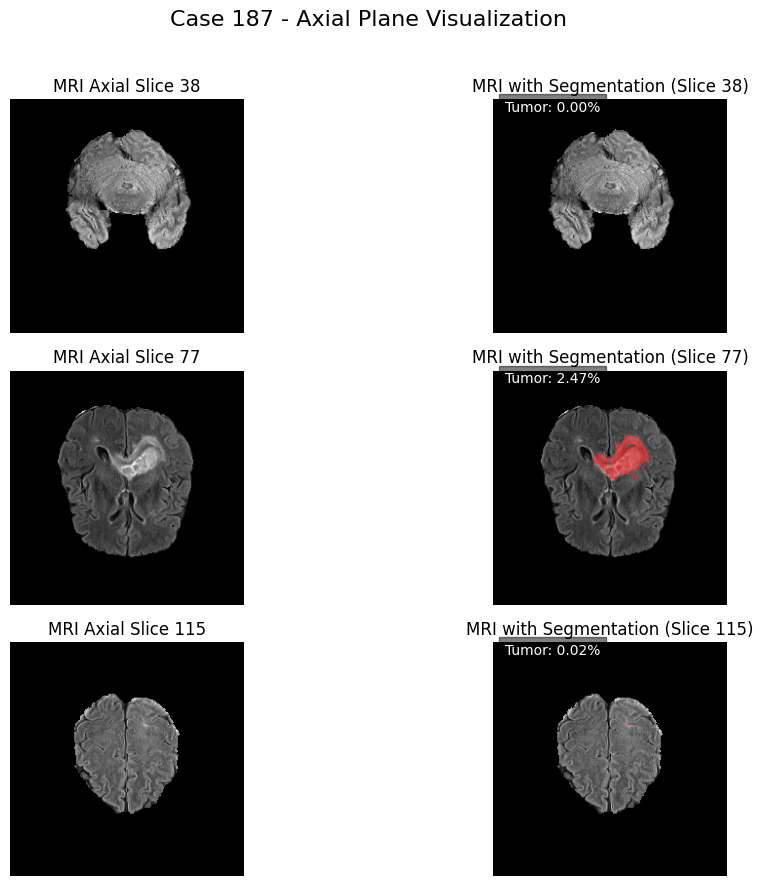


--- Visualizing Val Dataset ---

Visualizing case: 151
Case 151 volume dimensions: (240, 240, 155)


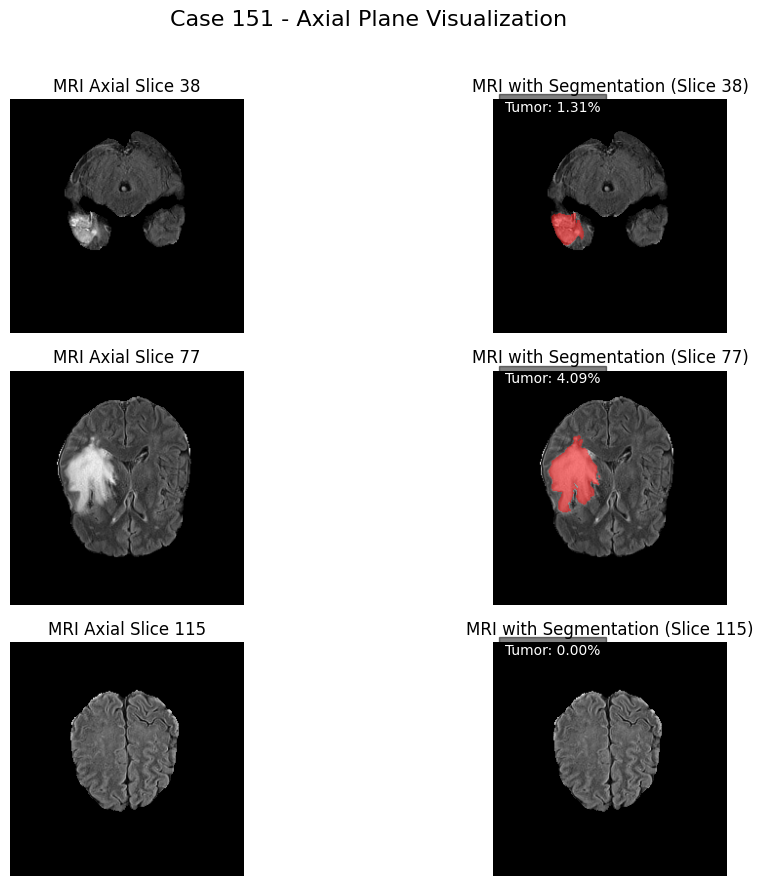

In [6]:
visualize_dataset(num_cases=1, num_slices=3, save_dir=None)

## Data preprocessing (Optional)

Images in the original dataset are usually of different sizes, so sometimes we need to resize and normalise them (z-score is commonly used in preprocessing MRI images) to fit the CNN model. Depending on the images you choose to use for training your model, you may need to apply other preprocessing methods. If preprocessing methods like cropping are applied, remember to convert the segmentation result back to its original size.

## Train-time data augmentation
Generalizability is crucial to a deep learning model, and it refers to the performance difference of a model when evaluated on seen data (training data) versus unseen data (testing data). Improving the generalizability of these models has always been a difficult challenge. 

**Data Augmentation** is an effective way of improving generalizability, because the augmented data will represent a more comprehensive set of possible data samples and minimize the distance between the training and validation/testing sets.

There are many data augmentation methods you can choose from in this project, including rotation, shifting, flipping, etc. PyTorch provides excellent data augmentation capabilities through torchvision.transforms, which you can combine with custom transforms for medical imaging.

You are encouraged to try different augmentation methods to get the best segmentation result.


## Get the data generator ready

In [7]:
class BrainTumorSegmentationDataset(Dataset):
    def __init__(self, case_dirs, augment=False):
        self.case_dirs = case_dirs
        self.augment = augment

        # Define preprocessing transforms
        self.preprocessing = tio.Compose([
            tio.Resize((128, 128, 64)),
            tio.RescaleIntensity(out_min_max=(0, 1)),
        ])

        # Define augmentation transforms
        if self.augment:
            self.transforms = tio.Compose([
                tio.RandomFlip(axes=(0, 1), flip_probability=0.5),
                tio.RandomAffine(
                    scales=(0.9, 1.1),
                    degrees=10,
                    translation=(10, 10, 5),
                    p=0.5
                ),
                tio.RandomNoise(std=(0, 0.1), p=0.3),
            ])
        else:
            self.transforms = None

    def __len__(self):
        return len(self.case_dirs)

    def __getitem__(self, idx):
        case_dir = self.case_dirs[idx]
        case_name = os.path.basename(case_dir)

        # Load MRI and segmentation files
        mri_path = os.path.join(case_dir, f"{case_name.split('_')[-1]}_fla.nii.gz")
        seg_path = os.path.join(case_dir, f"{case_name.split('_')[-1]}_seg.nii.gz")

        # Load using torchio
        subject = tio.Subject(
            mri=tio.ScalarImage(mri_path),
            seg=tio.LabelMap(seg_path)
        )

        # Apply preprocessing
        subject = self.preprocessing(subject)

        # Apply augmentation
        if self.transforms:
            subject = self.transforms(subject)

        # Get tensors
        mri_tensor = subject.mri.data.float()  # Shape: (1, H, W, D)
        seg_tensor = subject.seg.data.long()   # Shape: (1, H, W, D)
        seg_tensor = (seg_tensor > 0).long()   # Binary segmentation

        # 随机选择一个 axial slice
        depth = mri_tensor.shape[-1]
        slice_idx = torch.randint(0, depth, (1,)).item()
        
        # 提取 2D slice
        mri_slice = mri_tensor[:, :, :, slice_idx]  # Shape: (1, H, W)
        seg_slice = seg_tensor[:, :, :, slice_idx]  # Shape: (1, H, W)

        return mri_slice, seg_slice

In [8]:
# Prepare case directories
train_case_dirs = [os.path.join('Train', d) for d in os.listdir('Train') if not d.startswith('.')]
val_case_dirs = [os.path.join('Val', d) for d in os.listdir('Val') if not d.startswith('.')]

# Create datasets
train_dataset = BrainTumorSegmentationDataset(train_case_dirs, augment=True)
val_dataset = BrainTumorSegmentationDataset(val_case_dirs, augment=False)

# Create data loaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}, batches: {len(train_loader)}")
print(f"Validation samples: {len(val_dataset)}, batches: {len(val_loader)}")

Training samples: 168, batches: 42
Validation samples: 42, batches: 11


## Define a metric for the performance of the model
The Dice score is used here to evaluate the performance of your model.
More details about the Dice score and other metrics can be found at 
https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2. The Dice score can also be used as the loss function for training your model.

In [9]:
def binary_dice_score(pred: torch.Tensor, target: torch.Tensor, smooth: float = 1e-6) -> torch.Tensor:
    """
    Compute Dice Score for binary segmentation
    
    Args:
        pred: Predictions tensor of shape (N, 1, H, W) or (N, H, W)
        target: Ground truth tensor of same shape (binary: 0 or 1)
        smooth: Smoothing factor to avoid division by zero
    
    Returns:
        Dice score tensor of shape (N,) - dice score per sample
    """
    # Flatten tensors
    pred_flat = pred.view(pred.size(0), -1)
    target_flat = target.view(target.size(0), -1)
    
    # Compute intersection and union
    intersection = (pred_flat * target_flat).sum(dim=1)
    pred_sum = pred_flat.sum(dim=1)
    target_sum = target_flat.sum(dim=1)
    
    # Compute dice score
    dice = (2. * intersection + smooth) / (pred_sum + target_sum + smooth)
    
    return dice

def binary_dice_score_batch(pred: torch.Tensor, target: torch.Tensor, smooth: float = 1e-6) -> float:
    """
    Compute Dice Score for entire batch (single scalar)
    
    Returns:
        Average dice score across all samples in batch
    """
    dice_scores = binary_dice_score(pred, target, smooth)
    return dice_scores.mean().item()

In [10]:
class DiceLoss(nn.Module):
    def __init__(self, smooth: float = 1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """
        Compute Dice Loss
        
        Args:
            pred: Predictions (logits or probabilities) of shape (N, 1, H, W)
            target: Ground truth of same shape (binary: 0 or 1)
        
        Returns:
            Dice loss (scalar tensor)
        """
        # Apply sigmoid if pred are logits
        if pred.requires_grad:  # Assume logits
            pred = torch.sigmoid(pred)
        
        # Flatten
        pred_flat = pred.view(pred.size(0), -1)
        target_flat = target.view(target.size(0), -1)
        
        # Compute intersection and union
        intersection = (pred_flat * target_flat).sum()
        pred_sum = pred_flat.sum()
        target_sum = target_flat.sum()
        
        # Compute dice loss
        dice = (2. * intersection + self.smooth) / (pred_sum + target_sum + self.smooth)
        loss = 1 - dice
        
        return loss

## Build your own model here
The U-Net (https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28) structure is widely used for medical image segmentation tasks. You can build your own model or modify the U-Net by changing the hyperparameters for our task. If you choose to use PyTorch, more information about PyTorch layers, including Conv2d, MaxPool2d, and Dropout, can be found at https://pytorch.org/docs/stable/nn.html. You can also explore popular PyTorch implementations of U-Net for medical image segmentation.

In [11]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, init_features=32):
        """
        U-Net for medical image segmentation
        
        Args:
            in_channels (int): Number of input channels (e.g., 1 for grayscale MRI)
            out_channels (int): Number of output channels (1 for binary segmentation)
            init_features (int): Number of features in the first layer
        """
        super(UNet, self).__init__()
        
        features = init_features
        
        # Encoder (Contracting Path)
        self.encoder1 = self._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.encoder2 = self._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.encoder3 = self._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.encoder4 = self._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Bottleneck
        self.bottleneck = self._block(features * 8, features * 16, name="bottleneck")
        
        # Decoder (Expansive Path)
        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = self._block((features * 8) * 2, features * 8, name="dec4")
        
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = self._block((features * 4) * 2, features * 4, name="dec3")
        
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = self._block((features * 2) * 2, features * 2, name="dec2")
        
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = self._block(features * 2, features, name="dec1")
        
        # Final output layer
        self.conv_out = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )
        
    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool4(enc4))
        
        # Decoder with skip connections
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        # Output
        output = self.conv_out(dec1)
        return output
    
    def _block(self, in_channels, out_channels, name):
        """Helper function to create a double convolution block"""
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

## Train your model here
Once you have defined the model and data generator, you can start training your model. In PyTorch, you'll need to set up the training loop with the optimizer, loss function, and implement forward and backward passes manually.

In [12]:
# Training function for segmentation
def train_epoch(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    running_dice = 0.0
    
    # Progress bar
    with tqdm(total=len(train_loader), desc=f"Training Epoch {epoch+1}", unit="batch") as pbar:
        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)
            
            # Ensure targets are float for Dice loss
            targets = targets.float()
            
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)  # Dice Loss
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Calculate Dice Score for monitoring
            with torch.no_grad():
                pred_proba = torch.sigmoid(outputs)
                pred_binary = (pred_proba > 0.5).float()
                dice_score = binary_dice_score_batch(pred_binary, targets)
                running_dice += dice_score
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'dice': f'{dice_score:.4f}'
            })
            pbar.update(1)
    
    epoch_loss = running_loss / len(train_loader)
    epoch_dice = running_dice / len(train_loader)
    return epoch_loss, epoch_dice

# Validation function for segmentation
def validate_epoch(model, val_loader, criterion, device, epoch):
    model.eval()
    running_loss = 0.0
    running_dice = 0.0
    
    with tqdm(total=len(val_loader), desc=f"Validating Epoch {epoch+1}", unit="batch") as pbar:
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                targets = targets.float()
                
                outputs = model(data)
                loss = criterion(outputs, targets)  # Dice Loss
                
                running_loss += loss.item()
                
                # Calculate Dice Score
                pred_proba = torch.sigmoid(outputs)
                pred_binary = (pred_proba > 0.5).float()
                dice_score = binary_dice_score_batch(pred_binary, targets)
                running_dice += dice_score
                
                # Update progress bar
                pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'dice': f'{dice_score:.4f}'
                })
                pbar.update(1)
    
    epoch_loss = running_loss / len(val_loader)
    epoch_dice = running_dice / len(val_loader)
    return epoch_loss, epoch_dice

In [13]:
# Training loop with early stopping
def train_segmentation_model(model, train_loader, val_loader, num_epochs=50, patience=10):
    """
    Train segmentation model with Dice loss and Dice score monitoring
    """
    # Move model to device
    model = model.to(device)
    
    # Use Dice Loss
    # criterion = DiceLoss()
    criterion = nn.BCEWithLogitsLoss()
    
    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
    
    # Learning rate scheduler (optional)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', patience=5, factor=0.5
    )
    
    # Early stopping variables
    best_val_dice = 0.0
    patience_counter = 0
    
    # History tracking
    train_losses = []
    train_dices = []
    val_losses = []
    val_dices = []
    
    print("Starting segmentation training...")
    print(f"Using device: {device}")
    print("-" * 60)
    
    for epoch in range(num_epochs):
        # Train
        train_loss, train_dice = train_epoch(model, train_loader, criterion, optimizer, device, epoch)
        
        # Validate
        val_loss, val_dice = validate_epoch(model, val_loader, criterion, device, epoch)
        
        # Update learning rate
        scheduler.step(val_dice)
        
        # Store history
        train_losses.append(train_loss)
        train_dices.append(train_dice)
        val_losses.append(val_loss)
        val_dices.append(val_dice)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}')
        
        # Early stopping and model saving
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            patience_counter = 0
            # Save best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_dice': best_val_dice,
            }, 'best_segmentation_model.pth')
            print(f'  🎯 New best model saved! Val Dice: {best_val_dice:.4f}')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
        
        print('-' * 60)
    
    print(f'Training completed! Best validation Dice score: {best_val_dice:.4f}')
    
    # Return training history
    history = {
        'train_losses': train_losses,
        'train_dices': train_dices,
        'val_losses': val_losses,
        'val_dices': val_dices,
        'best_val_dice': best_val_dice
    }
    
    return history

In [13]:
unet_model = UNet(in_channels=1, out_channels=1, init_features=32)
unet_model = unet_model.to(device)

history = train_segmentation_model(
    model=unet_model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=30,
    patience=10
)

Starting segmentation training...
Using device: cuda
------------------------------------------------------------


Validating Epoch 1: 100%|██████████| 11/11 [00:05<00:00,  1.92batch/s, loss=0.5203, dice=0.0122]


Epoch 1/30:
  Train Loss: 0.6412, Train Dice: 0.1906
  Val Loss: 0.5293, Val Dice: 0.2266
  🎯 New best model saved! Val Dice: 0.2266
------------------------------------------------------------


Validating Epoch 2: 100%|██████████| 11/11 [00:05<00:00,  1.91batch/s, loss=0.4599, dice=0.6957]


Epoch 2/30:
  Train Loss: 0.4922, Train Dice: 0.5121
  Val Loss: 0.4674, Val Dice: 0.7633
  🎯 New best model saved! Val Dice: 0.7633
------------------------------------------------------------


Validating Epoch 3: 100%|██████████| 11/11 [00:05<00:00,  1.91batch/s, loss=0.3194, dice=1.0000]


Epoch 3/30:
  Train Loss: 0.4099, Train Dice: 0.5682
  Val Loss: 0.3459, Val Dice: 0.7241
------------------------------------------------------------


Validating Epoch 4: 100%|██████████| 11/11 [00:05<00:00,  1.96batch/s, loss=0.3250, dice=0.8164]


Epoch 4/30:
  Train Loss: 0.3382, Train Dice: 0.5919
  Val Loss: 0.5199, Val Dice: 0.5621
------------------------------------------------------------


Validating Epoch 5: 100%|██████████| 11/11 [00:05<00:00,  1.95batch/s, loss=0.2860, dice=0.7669]


Epoch 5/30:
  Train Loss: 0.2861, Train Dice: 0.5672
  Val Loss: 0.3046, Val Dice: 0.6865
------------------------------------------------------------


Validating Epoch 6: 100%|██████████| 11/11 [00:05<00:00,  2.03batch/s, loss=0.2520, dice=0.5000]


Epoch 6/30:
  Train Loss: 0.2371, Train Dice: 0.5715
  Val Loss: 0.2602, Val Dice: 0.6751
------------------------------------------------------------


Validating Epoch 7: 100%|██████████| 11/11 [00:05<00:00,  1.93batch/s, loss=0.1989, dice=0.4050]


Epoch 7/30:
  Train Loss: 0.1991, Train Dice: 0.6910
  Val Loss: 0.2051, Val Dice: 0.6341
------------------------------------------------------------


Validating Epoch 8: 100%|██████████| 11/11 [00:05<00:00,  1.98batch/s, loss=0.1546, dice=1.0000]


Epoch 8/30:
  Train Loss: 0.1700, Train Dice: 0.6154
  Val Loss: 0.1699, Val Dice: 0.8217
  🎯 New best model saved! Val Dice: 0.8217
------------------------------------------------------------


Validating Epoch 9: 100%|██████████| 11/11 [00:05<00:00,  1.88batch/s, loss=0.1409, dice=0.8841]


Epoch 9/30:
  Train Loss: 0.1450, Train Dice: 0.5969
  Val Loss: 0.1462, Val Dice: 0.6779
------------------------------------------------------------


Validating Epoch 10: 100%|██████████| 11/11 [00:06<00:00,  1.66batch/s, loss=0.1223, dice=0.4170]


Epoch 10/30:
  Train Loss: 0.1245, Train Dice: 0.6514
  Val Loss: 0.1285, Val Dice: 0.7065
------------------------------------------------------------


Validating Epoch 11: 100%|██████████| 11/11 [00:07<00:00,  1.50batch/s, loss=0.0890, dice=0.8465]


Epoch 11/30:
  Train Loss: 0.1071, Train Dice: 0.6181
  Val Loss: 0.0990, Val Dice: 0.7167
------------------------------------------------------------


Validating Epoch 12: 100%|██████████| 11/11 [00:06<00:00,  1.66batch/s, loss=0.0733, dice=1.0000]


Epoch 12/30:
  Train Loss: 0.0966, Train Dice: 0.6157
  Val Loss: 0.0899, Val Dice: 0.6908
------------------------------------------------------------


Validating Epoch 13: 100%|██████████| 11/11 [00:05<00:00,  1.91batch/s, loss=0.0746, dice=0.7466]


Epoch 13/30:
  Train Loss: 0.0853, Train Dice: 0.6252
  Val Loss: 0.0767, Val Dice: 0.7630
------------------------------------------------------------


Validating Epoch 14: 100%|██████████| 11/11 [00:05<00:00,  1.88batch/s, loss=0.0569, dice=1.0000]


Epoch 14/30:
  Train Loss: 0.0778, Train Dice: 0.6213
  Val Loss: 0.0693, Val Dice: 0.7641
------------------------------------------------------------


Validating Epoch 15: 100%|██████████| 11/11 [00:05<00:00,  2.05batch/s, loss=0.0627, dice=0.8806]


Epoch 15/30:
  Train Loss: 0.0649, Train Dice: 0.7083
  Val Loss: 0.0672, Val Dice: 0.7098
------------------------------------------------------------


Validating Epoch 16: 100%|██████████| 11/11 [00:05<00:00,  1.88batch/s, loss=0.0536, dice=0.5000]


Epoch 16/30:
  Train Loss: 0.0620, Train Dice: 0.6638
  Val Loss: 0.0591, Val Dice: 0.8257
  🎯 New best model saved! Val Dice: 0.8257
------------------------------------------------------------


Validating Epoch 17: 100%|██████████| 11/11 [00:05<00:00,  2.01batch/s, loss=0.0409, dice=0.5000]


Epoch 17/30:
  Train Loss: 0.0618, Train Dice: 0.6966
  Val Loss: 0.0540, Val Dice: 0.7800
------------------------------------------------------------


Validating Epoch 18: 100%|██████████| 11/11 [00:05<00:00,  1.95batch/s, loss=0.0400, dice=1.0000]


Epoch 18/30:
  Train Loss: 0.0608, Train Dice: 0.6415
  Val Loss: 0.0551, Val Dice: 0.8018
------------------------------------------------------------


Validating Epoch 19: 100%|██████████| 11/11 [00:05<00:00,  1.89batch/s, loss=0.0409, dice=0.7727]


Epoch 19/30:
  Train Loss: 0.0556, Train Dice: 0.6361
  Val Loss: 0.0480, Val Dice: 0.7345
------------------------------------------------------------


Validating Epoch 20: 100%|██████████| 11/11 [00:06<00:00,  1.81batch/s, loss=0.0345, dice=1.0000]


Epoch 20/30:
  Train Loss: 0.0553, Train Dice: 0.6021
  Val Loss: 0.0426, Val Dice: 0.7819
------------------------------------------------------------


Validating Epoch 21: 100%|██████████| 11/11 [00:06<00:00,  1.73batch/s, loss=0.0390, dice=0.8892]


Epoch 21/30:
  Train Loss: 0.0488, Train Dice: 0.6821
  Val Loss: 0.0478, Val Dice: 0.7535
------------------------------------------------------------


Validating Epoch 22: 100%|██████████| 11/11 [00:06<00:00,  1.66batch/s, loss=0.0437, dice=0.6876]


Epoch 22/30:
  Train Loss: 0.0437, Train Dice: 0.6317
  Val Loss: 0.0456, Val Dice: 0.7738
------------------------------------------------------------


Validating Epoch 23: 100%|██████████| 11/11 [00:06<00:00,  1.67batch/s, loss=0.0367, dice=0.7021]


Epoch 23/30:
  Train Loss: 0.0466, Train Dice: 0.6964
  Val Loss: 0.0406, Val Dice: 0.8056
------------------------------------------------------------


Validating Epoch 24: 100%|██████████| 11/11 [00:05<00:00,  1.93batch/s, loss=0.0353, dice=0.2516]


Epoch 24/30:
  Train Loss: 0.0465, Train Dice: 0.6678
  Val Loss: 0.0412, Val Dice: 0.6867
------------------------------------------------------------


Validating Epoch 25: 100%|██████████| 11/11 [00:06<00:00,  1.83batch/s, loss=0.0433, dice=0.7247]


Epoch 25/30:
  Train Loss: 0.0446, Train Dice: 0.7356
  Val Loss: 0.0454, Val Dice: 0.8020
------------------------------------------------------------


Validating Epoch 26: 100%|██████████| 11/11 [00:05<00:00,  1.96batch/s, loss=0.0299, dice=0.2903]

Epoch 26/30:
  Train Loss: 0.0452, Train Dice: 0.6761
  Val Loss: 0.0495, Val Dice: 0.6431
Early stopping triggered after 26 epochs
Training completed! Best validation Dice score: 0.8257


## Save the model
Once your model is trained, remember to save it for testing. In PyTorch, you can save the model state dictionary using torch.save() for later loading and inference.

## Run the model on the test set
After your last Q&A session, you will be given the test set. Run your model on the test set to get the segmentation results and submit your results in a .zip file. If the MRI image is named '100_fla.nii.gz', save your segmentation result as '100_seg.nii.gz'. 

In [15]:
class BrainTumorInferenceDataset(Dataset):
    def __init__(self, case_dirs):
        """
        Inference Dataset for test data without labels
        """
        self.case_dirs = case_dirs
        
        # Preprocessing: resize to model input size
        self.preprocessing = tio.Compose([
            tio.Resize((128, 128, 64)),  # Resize to model input size
            tio.RescaleIntensity(out_min_max=(0, 1)),  # Normalize intensity
        ])

    def __len__(self):
        return len(self.case_dirs)

    def __getitem__(self, idx):
        case_dir = self.case_dirs[idx]
        case_name = os.path.basename(case_dir)

        # Load MRI file
        mri_path = os.path.join(case_dir, f"{case_name.split('_')[-1]}_fla.nii.gz")
        mri_subject = tio.Subject(mri=tio.ScalarImage(mri_path))
        
        # Get original dimensions
        original_tensor = mri_subject.mri.data.float()
        original_shape = original_tensor.shape  # [1, H, W, D]
        original_size = torch.tensor([original_shape[1], original_shape[2], original_shape[3]])
        
        # Get original affine matrix
        original_affine = mri_subject.mri.affine
        
        # Preprocess for model input
        processed_subject = self.preprocessing(mri_subject)
        processed_tensor = processed_subject.mri.data.float()  # [1, 128, 128, 64]

        return processed_tensor, case_name, original_size, original_affine

In [16]:
def load_trained_model(model_path, device):
    """
    Load trained model from checkpoint
    """
    model = UNet(in_channels=1, out_channels=1, init_features=32)
    model = model.to(device)
    
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"Model loaded from {model_path}")
    if 'best_val_dice' in checkpoint:
        print(f"Best validation Dice: {checkpoint['best_val_dice']:.4f}")
    
    return model

In [22]:
def generate_predictions(model, data_loader, device, output_dir='submission'):
    """
    Generate predictions matching original dimensions and proper naming
    """
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    
    with torch.no_grad():
        for batch_idx, (processed_data, case_names, original_sizes, original_affines) in enumerate(tqdm(data_loader, desc="Generating Predictions")):
            processed_data = processed_data.to(device)  # [batch, 1, 128, 128, 64]
            
            batch_size = processed_data.shape[0]
            
            for i in range(batch_size):
                case_name = case_names[i] if isinstance(case_names, (list, tuple)) else case_names
                
                # Process original size information
                if hasattr(original_sizes, 'cpu'):
                    orig_size_tensor = original_sizes[i].cpu()
                else:
                    orig_size_tensor = original_sizes[i]
                
                orig_h, orig_w, orig_d = map(int, orig_size_tensor.tolist())
                original_affine = original_affines[i].cpu().numpy() if hasattr(original_affines[i], 'cpu') else original_affines[i]
                
                print(f"Processing case {case_name}")
                print(f"  Original size: ({orig_h}, {orig_w}, {orig_d})")
                
                # Process full 3D volume slice by slice
                volume_3d = processed_data[i].squeeze(0)  # [128, 128, 64]
                predicted_3d = torch.zeros_like(volume_3d)  # [128, 128, 64]
                
                # Predict slice by slice
                for slice_idx in range(volume_3d.shape[2]):
                    slice_2d = volume_3d[:, :, slice_idx].unsqueeze(0)  # [1, 128, 128]
                    
                    # Model prediction
                    output = model(slice_2d.unsqueeze(0).to(device))  # [1, 1, 128, 128]
                    pred_proba = torch.sigmoid(output)
                    pred_binary = (pred_proba > 0.5).float()
                    
                    # Save prediction result
                    predicted_3d[:, :, slice_idx] = pred_binary.squeeze()
                
                # Convert to numpy
                predicted_np = predicted_3d.cpu().numpy()  # [128, 128, 64]
                
                # Resize to original dimensions
                zoom_h = orig_h / 128
                zoom_w = orig_w / 128
                zoom_d = orig_d / 64
                
                # Use nearest neighbor interpolation for resizing
                final_prediction = zoom(predicted_np, (zoom_h, zoom_w, zoom_d), order=0)
                
                # Ensure binary output
                final_prediction = (final_prediction > 0.5).astype(np.float32)
                
                # Save with proper naming convention: '100_seg.nii.gz' for '100_fla.nii.gz'
                case_id = case_name.split('_')[-1]  # Extract case ID
                output_filename = f"{case_id}_seg.nii.gz"
                output_path = os.path.join(output_dir, output_filename)
                
                # Save as NIfTI file
                nii_img = nib.Nifti1Image(final_prediction, affine=original_affine)
                nib.save(nii_img, output_path)
                
                print(f"✅ Saved prediction: {output_filename}")
                print(f"  Shape: {final_prediction.shape}")
                print(f"  Unique values: {np.unique(final_prediction)}")

In [23]:
def create_submission_zip(submission_dir='submission', zip_filename='submission.zip'):
    """
    Create ZIP file for submission
    """
    if not os.path.exists(submission_dir):
        print(f"❌ Submission directory not found: {submission_dir}")
        return None
    
    # Get all prediction files
    pred_files = [f for f in os.listdir(submission_dir) if f.endswith('_seg.nii.gz')]
    
    if len(pred_files) == 0:
        print("❌ No prediction files found for submission")
        return None
    
    print(f"Creating submission ZIP with {len(pred_files)} files...")
    
    # Create ZIP file
    zip_path = zip_filename
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for file in pred_files:
            file_path = os.path.join(submission_dir, file)
            zipf.write(file_path, file)  # Add file to ZIP with proper name
            print(f"  Added to ZIP: {file}")
    
    print(f"✅ Submission ZIP created: {zip_path}")
    print(f"   ZIP file size: {os.path.getsize(zip_path) / (1024*1024):.2f} MB")
    
    return zip_path

In [24]:
def run_submission_pipeline():
    """
    Complete pipeline for generating submission results
    """
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    
    # Prepare test data paths
    test_case_dirs = [os.path.join('test', d) for d in os.listdir('test') 
                     if not d.startswith('.') and os.path.isdir(os.path.join('test', d))]
    print(f"Test samples: {len(test_case_dirs)}")
    
    if len(test_case_dirs) == 0:
        print("❌ No test cases found!")
        return None
    
    # Create inference dataset
    inference_dataset = BrainTumorInferenceDataset(test_case_dirs)
    
    # Create inference data loader
    inference_loader = DataLoader(
        inference_dataset, 
        batch_size=1,  # Use batch_size=1 for memory efficiency
        shuffle=False, 
        num_workers=0
    )
    
    print(f"Inference batches: {len(inference_loader)}")
    
    # Load trained model
    print("Loading trained model...")
    model = load_trained_model('best_segmentation_model.pth', device)
    
    # Clean previous submission directory
    submission_dir = 'submission'
    if os.path.exists(submission_dir):
        shutil.rmtree(submission_dir)
        print(f"Cleaned previous submission directory: {submission_dir}")
    
    # Generate predictions with proper naming
    print("Generating predictions for submission...")
    generate_predictions(model, inference_loader, device, submission_dir)
    
    # Create submission ZIP
    print("Creating submission ZIP file...")
    zip_path = create_submission_zip(submission_dir, 'submission.zip')
    
    return zip_path

In [25]:
zip_file = run_submission_pipeline()
if zip_file:
    print(f"\n🎉 Submission complete!")
    print(f"   Submission file: {zip_file}")
    print(f"   Ready for upload!")
else:
    print(f"\n❌ Submission failed!")

Using device: cuda
Test samples: 41
Inference batches: 41
Loading trained model...
Model loaded from best_segmentation_model.pth
Best validation Dice: 0.8257
Cleaned previous submission directory: submission
Generating predictions for submission...


Generating Predictions:   0%|          | 0/41 [00:00<?, ?it/s]

Processing case 229
  Original size: (240, 240, 155)


Generating Predictions:   2%|▏         | 1/41 [00:00<00:36,  1.10it/s]

✅ Saved prediction: 229_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 227
  Original size: (240, 240, 155)


Generating Predictions:   5%|▍         | 2/41 [00:01<00:28,  1.38it/s]

✅ Saved prediction: 227_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 217
  Original size: (240, 240, 155)


Generating Predictions:   7%|▋         | 3/41 [00:02<00:26,  1.46it/s]

✅ Saved prediction: 217_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 219
  Original size: (240, 240, 155)


Generating Predictions:  10%|▉         | 4/41 [00:02<00:24,  1.51it/s]

✅ Saved prediction: 219_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 240
  Original size: (240, 240, 155)


Generating Predictions:  12%|█▏        | 5/41 [00:03<00:23,  1.52it/s]

✅ Saved prediction: 240_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 249
  Original size: (240, 240, 155)


Generating Predictions:  15%|█▍        | 6/41 [00:04<00:22,  1.57it/s]

✅ Saved prediction: 249_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 225
  Original size: (240, 240, 155)


Generating Predictions:  17%|█▋        | 7/41 [00:04<00:21,  1.60it/s]

✅ Saved prediction: 225_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 244
  Original size: (240, 240, 155)


Generating Predictions:  20%|█▉        | 8/41 [00:05<00:20,  1.59it/s]

✅ Saved prediction: 244_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 247
  Original size: (240, 240, 155)


Generating Predictions:  22%|██▏       | 9/41 [00:05<00:19,  1.65it/s]

✅ Saved prediction: 247_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 226
  Original size: (240, 240, 155)


Generating Predictions:  24%|██▍       | 10/41 [00:06<00:18,  1.67it/s]

✅ Saved prediction: 226_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 245
  Original size: (240, 240, 155)


Generating Predictions:  27%|██▋       | 11/41 [00:07<00:18,  1.64it/s]

✅ Saved prediction: 245_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 216
  Original size: (240, 240, 155)


Generating Predictions:  29%|██▉       | 12/41 [00:07<00:18,  1.60it/s]

✅ Saved prediction: 216_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 228
  Original size: (240, 240, 155)


Generating Predictions:  32%|███▏      | 13/41 [00:08<00:17,  1.61it/s]

✅ Saved prediction: 228_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 215
  Original size: (240, 240, 155)


Generating Predictions:  34%|███▍      | 14/41 [00:08<00:16,  1.63it/s]

✅ Saved prediction: 215_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 243
  Original size: (240, 240, 155)


Generating Predictions:  37%|███▋      | 15/41 [00:09<00:15,  1.64it/s]

✅ Saved prediction: 243_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 241
  Original size: (240, 240, 155)


Generating Predictions:  39%|███▉      | 16/41 [00:10<00:15,  1.65it/s]

✅ Saved prediction: 241_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 248
  Original size: (240, 240, 155)


Generating Predictions:  41%|████▏     | 17/41 [00:10<00:14,  1.61it/s]

✅ Saved prediction: 248_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 239
  Original size: (240, 240, 155)


Generating Predictions:  44%|████▍     | 18/41 [00:11<00:14,  1.60it/s]

✅ Saved prediction: 239_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 238
  Original size: (240, 240, 155)


Generating Predictions:  46%|████▋     | 19/41 [00:11<00:13,  1.61it/s]

✅ Saved prediction: 238_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 211
  Original size: (240, 240, 155)


Generating Predictions:  49%|████▉     | 20/41 [00:12<00:12,  1.65it/s]

✅ Saved prediction: 211_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 242
  Original size: (240, 240, 155)


Generating Predictions:  51%|█████     | 21/41 [00:13<00:12,  1.64it/s]

✅ Saved prediction: 242_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 218
  Original size: (240, 240, 155)


Generating Predictions:  54%|█████▎    | 22/41 [00:13<00:11,  1.66it/s]

✅ Saved prediction: 218_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 234
  Original size: (240, 240, 155)


Generating Predictions:  56%|█████▌    | 23/41 [00:14<00:11,  1.63it/s]

✅ Saved prediction: 234_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 231
  Original size: (240, 240, 155)


Generating Predictions:  59%|█████▊    | 24/41 [00:15<00:10,  1.62it/s]

✅ Saved prediction: 231_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 250
  Original size: (240, 240, 155)


Generating Predictions:  61%|██████    | 25/41 [00:15<00:09,  1.62it/s]

✅ Saved prediction: 250_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 213
  Original size: (240, 240, 155)


Generating Predictions:  63%|██████▎   | 26/41 [00:16<00:09,  1.61it/s]

✅ Saved prediction: 213_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 235
  Original size: (240, 240, 155)


Generating Predictions:  66%|██████▌   | 27/41 [00:16<00:08,  1.60it/s]

✅ Saved prediction: 235_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 236
  Original size: (240, 240, 155)


Generating Predictions:  68%|██████▊   | 28/41 [00:17<00:08,  1.61it/s]

✅ Saved prediction: 236_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 220
  Original size: (240, 240, 155)


Generating Predictions:  71%|███████   | 29/41 [00:18<00:07,  1.66it/s]

✅ Saved prediction: 220_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 212
  Original size: (240, 240, 155)


Generating Predictions:  73%|███████▎  | 30/41 [00:18<00:06,  1.64it/s]

✅ Saved prediction: 212_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 223
  Original size: (240, 240, 155)


Generating Predictions:  76%|███████▌  | 31/41 [00:19<00:06,  1.63it/s]

✅ Saved prediction: 223_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 221
  Original size: (240, 240, 155)


Generating Predictions:  78%|███████▊  | 32/41 [00:19<00:05,  1.63it/s]

✅ Saved prediction: 221_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 251
  Original size: (240, 240, 155)


Generating Predictions:  80%|████████  | 33/41 [00:20<00:04,  1.63it/s]

✅ Saved prediction: 251_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 233
  Original size: (240, 240, 155)


Generating Predictions:  83%|████████▎ | 34/41 [00:21<00:04,  1.63it/s]

✅ Saved prediction: 233_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 230
  Original size: (240, 240, 155)


Generating Predictions:  85%|████████▌ | 35/41 [00:21<00:03,  1.63it/s]

✅ Saved prediction: 230_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 237
  Original size: (240, 240, 155)


Generating Predictions:  88%|████████▊ | 36/41 [00:22<00:03,  1.59it/s]

✅ Saved prediction: 237_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 214
  Original size: (240, 240, 155)


Generating Predictions:  90%|█████████ | 37/41 [00:23<00:02,  1.52it/s]

✅ Saved prediction: 214_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 224
  Original size: (240, 240, 155)


Generating Predictions:  93%|█████████▎| 38/41 [00:23<00:01,  1.52it/s]

✅ Saved prediction: 224_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 232
  Original size: (240, 240, 155)


Generating Predictions:  95%|█████████▌| 39/41 [00:24<00:01,  1.54it/s]

✅ Saved prediction: 232_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 222
  Original size: (240, 240, 155)


Generating Predictions:  98%|█████████▊| 40/41 [00:25<00:00,  1.57it/s]

✅ Saved prediction: 222_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Processing case 246
  Original size: (240, 240, 155)


Generating Predictions: 100%|██████████| 41/41 [00:25<00:00,  1.60it/s]

✅ Saved prediction: 246_seg.nii.gz
  Shape: (240, 240, 155)
  Unique values: [0. 1.]
Creating submission ZIP file...
Creating submission ZIP with 41 files...
  Added to ZIP: 212_seg.nii.gz
  Added to ZIP: 222_seg.nii.gz
  Added to ZIP: 218_seg.nii.gz
  Added to ZIP: 240_seg.nii.gz
  Added to ZIP: 241_seg.nii.gz
  Added to ZIP: 234_seg.nii.gz
  Added to ZIP: 235_seg.nii.gz
  Added to ZIP: 217_seg.nii.gz
  Added to ZIP: 214_seg.nii.gz
  Added to ZIP: 213_seg.nii.gz
  Added to ZIP: 237_seg.nii.gz
  Added to ZIP: 239_seg.nii.gz
  Added to ZIP: 219_seg.nii.gz
  Added to ZIP: 244_seg.nii.gz
  Added to ZIP: 250_seg.nii.gz
  Added to ZIP: 224_seg.nii.gz
  Added to ZIP: 238_seg.nii.gz
  Added to ZIP: 246_seg.nii.gz
  Added to ZIP: 228_seg.nii.gz
  Added to ZIP: 242_seg.nii.gz
  Added to ZIP: 223_seg.nii.gz
  Added to ZIP: 247_seg.nii.gz
  Added to ZIP: 236_seg.nii.gz
  Added to ZIP: 249_seg.nii.gz
  Added to ZIP: 245_seg.nii.gz
  Added to ZIP: 227_seg.nii.gz
  Added to ZIP: 211_seg.nii.gz
  Add